# Full Live Coding - Intro to Neural Networks
---

# 🌌 Project: Hunting for Gamma Rays with NNs

**The Mission** Imagine you are an astrophysicist working at the **MAGIC Telescope** in the Canary Islands. Your goal is to detect high-energy **Gamma Rays** coming from extreme cosmic events like black holes and supernovas. However, this is difficult because the Earth’s atmosphere is constantly bombarded by ordinary cosmic rays (protons/hadrons), which create massive amounts of "background noise."

**The Data** When these particles hit the atmosphere, they create faint blue flashes of light (Cherenkov Radiation). The telescope captures these flashes, which appear as oval shapes on the camera. Instead of processing raw images, this dataset gives us **10 geometric measurements** of these shapes—such as their length, width, and orientation—mathematically describing exactly what the flash looked like.

We have a dataset of **19,000 observations**. We build a **Neural Network** that acts as the brain of the telescope. It must look at these 10 numerical measurements and classify each incoming particle as either a rare **Gamma Ray (Signal)** or common **Hadron (Background Noise)**.

In [1]:
#pip install tensorflow
#pip install pydot (for mac==2.0.0)
#pip install graphviz (for mac==2.50.0)
# !uv pip install tensorflow==2.15.0 tensorflow-metal==1.1.0

In [68]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report


In [3]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Success! TensorFlow Metal is active. Found {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("❌ No GPU found. Make sure 'tensorflow-metal' is installed.")

✅ Success! TensorFlow Metal is active. Found 1 GPU(s):
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [52]:
# 1. Load Data directly from UCI Archive
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"
# The file has no headers, so we name them manually based on documentation
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", 
        "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]

df = pd.read_csv(url, names=cols)

In [53]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [54]:
df.shape


(19020, 11)

In [55]:
# 2. Map Class to Binary (g = Gamma (Signal) = 1, h = Hadron (Background) = 0)
df['class'] = df['class'].map({'g': 1, 'h': 0})

In [56]:
df.isnull().sum().sum()

0

In [57]:
# 3. Features vs Labels
X = df.drop('class', axis=1).values
y = df['class'].values

In [58]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [59]:
# 4. Split Data (Standard 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# 5. Scale the Data (CRITICAL for Deep Learning)
# Neural Networks fail if inputs are not scaled (e.g., 0-1 or standard normal)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
print(f"Training Data Shape: {X_train.shape}")
print(f"Sample Records:\n{X_train[:3]}")

Training Data Shape: (15216, 10)
Sample Records:
[[-0.54294179 -0.62738866 -0.64590104  0.26051989  0.52311744  0.0645751
  -0.46014325 -0.21610391  1.47665244 -0.8437807 ]
 [-0.66573322 -0.50919261 -0.80101361  0.49466661  0.39620272  0.43577801
  -0.03763703 -0.36543949 -0.04132548 -0.51586452]
 [-0.69143496 -0.34756347 -0.53141822  0.18973135  0.28278956  0.40780535
  -0.36310239  0.2093676   0.12281918 -0.82694425]]


### From Here Down we will create the NN model

**Sequential Model Initialization:**

This line initializes a new Neural Network model that is sequential in nature, meaning that the model consists of a linear stack of layers.

**Adding the first layer:**

Here we will add the first layer to the model, which is a densely-connected (also known as a fully connected) layer. This is done  using the Dense class.

- 32: This will be the number of neurons in the layer. 32 Neurons is potentially a common choice for a moderate-sized layer.
- input_shape = (X_train.shape[1],): This specifies the shape of the input data that thos layer will receive. This is the number of features (columns) in the training data.
- You only need to specify the input shape for the first layer in a Keras model.
- Subsequent layers can do automatic shape inference
- activation = 'relu': This specifies the activation function for the neurons in this layer. Relu stands for Rectified Linear Unit and it's a linearr function that will output the input directly if it is positive, otherwise it will output zero.
- It's a common activation function in a NN because it alows for faster training and reduced likelihood of the vanishing gradients problem.

**Adding the Output Layer:**

Next, you add the output layer, which is also a Dense layer. 1: Since this is a binary classification problem, you only need a single neuron in the output layer. This neuron will output a probability indicating how likely the input data is to belong to the positive class. activation='sigmoid': The sigmoid activation function is used to squish the output of the neuron into a range between 0 and 1, which is interpretable as a probability.

**Compiling the Model:**

Finally, you compile the model, which is a step where you specify:

- optimizer='adam': The optimizer is the algorithm used to update the weights of the network during training. adam is an adaptive learning rate optimizer and is generally a good default choice for many problems.
- loss='binary_crossentropy': This specifies the loss function to be used during training. For binary classification, binary_crossentropy is suitable because it measures the "distance" between the probability distribution output by the model and the true distribution of the labels. It is a measure of how wrong the model's predictions are.
- metrics=['accuracy']: During training, Keras will monitor the accuracy of the model, which is the fraction of correctly classified samples. This is a standard setup for a simple binary classification neural network in Keras. From here, you would proceed to train the model on your training data with the fit method and then evaluate its performance with the evaluate method or use it to make predictions.

In [ ]:
model_shallow = Sequential()
model_shallow.add(Dense(32, input_shape=(10,), activation='relu')) # 10 input features
model_shallow.add(Dense(1, activation='sigmoid'))

model_shallow.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [84]:
model_shallow.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                352       
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_shallow = model_shallow.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
428/428 [==============================] - 3s 7ms/step - loss: 0.5222 - accuracy: 0.7472 - val_loss: 0.4591 - val_accuracy: 0.7943
Epoch 2/20
428/428 [==============================] - 2s 6ms/step - loss: 0.4621 - accuracy: 0.7901 - val_loss: 0.4566 - val_accuracy: 0.7963
Epoch 3/20
428/428 [==============================] - 2s 6ms/step - loss: 0.4616 - accuracy: 0.7889 - val_loss: 0.4653 - val_accuracy: 0.7976
Epoch 4/20
428/428 [==============================] - 3s 6ms/step - loss: 0.4619 - accuracy: 0.7902 - val_loss: 0.4609 - val_accuracy: 0.8003
Epoch 5/20
428/428 [==============================] - 3s 6ms/step - loss: 0.4623 - accuracy: 0.7886 - val_loss: 0.4608 - val_accuracy: 0.7989
Epoch 6/20
428/428 [==============================] - 3s 6ms/step - loss: 0.4621 - accuracy: 0.7887 - val_loss: 0.4562 - val_accuracy: 0.7930
Epoch 7/20
428/428 [==============================] - 2s 6ms/step - loss: 0.4624 - accuracy: 0.7879 - val_loss: 0.4589 - val_accuracy: 0.7957
Epoch 

In [76]:
# 1. Reduce Learning Rate
# If the model gets stuck (validation loss doesn't improve for 5 epochs),
# we slow down the learning rate by 80% (factor=0.2) to help it find the minimum.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5,         # Wait 5 epochs before slowing down
    min_lr=0.00001,     # Allow it to drop as low as 0.00001 (CRITICAL FIX)
    verbose=1
)

# 2. Early Stopping
# If the model stops improving for 10 epochs, we stop training entirely 
# to save time and prevent overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,        # Wait 10 epochs before stopping
    restore_best_weights=True, # Go back to the best version of the model
    verbose=1
)

In [77]:
# Train the Shallow model using these callbacks
print("Training Shallow Model...")
history_shallow = model_shallow.fit(
    X_train, 
    y_train, 
    epochs=50,             # Give it plenty of room (EarlyStopping will cut it short)
    batch_size=32, 
    validation_split=0.1, 
    callbacks=[reduce_lr, early_stopping]
)

Training Shallow Model...
Epoch 1/50
428/428 [==============================] - 3s 8ms/step - loss: 0.4684 - accuracy: 0.7851 - val_loss: 0.4577 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 3s 8ms/step - loss: 0.4695 - accuracy: 0.7814 - val_loss: 0.4620 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 3s 8ms/step - loss: 0.4671 - accuracy: 0.7843 - val_loss: 0.4610 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 3s 7ms/step - loss: 0.4666 - accuracy: 0.7833 - val_loss: 0.4627 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 3s 6ms/step - loss: 0.4670 - accuracy: 0.7857 - val_loss: 0.5190 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 6/50
424/428 [============================>.] - ETA: 0s - loss: 0.4667 - accuracy: 0.7854
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
428/428 [=================

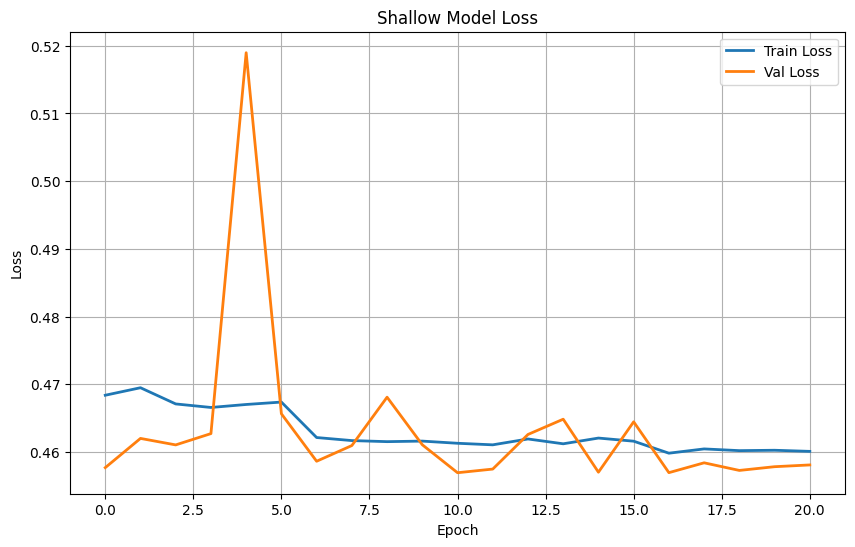

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(history_shallow.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_shallow.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Shallow Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

119/119 [==============================] - 0s 2ms/step


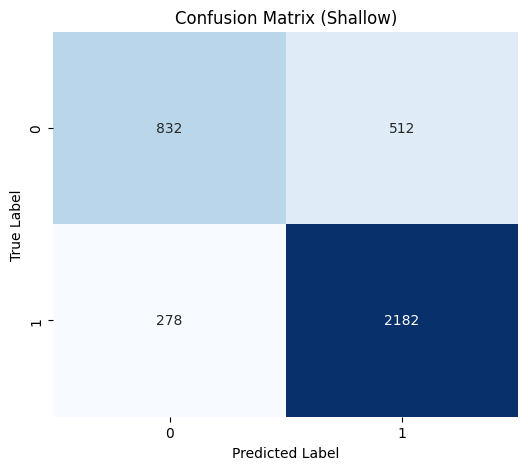

In [81]:
# --- 3. Confusion Matrix ---
# Predict classes (0 or 1)
y_pred_shallow = (model_shallow.predict(X_test) > 0.5).astype("int32")

# Generate Matrix
cm_shallow = confusion_matrix(y_test, y_pred_shallow)

# Plot Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_shallow, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Shallow)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [82]:
# Print Classification Report
print(classification_report(y_test, y_pred_shallow))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1344
           1       0.81      0.89      0.85      2460

    accuracy                           0.79      3804
   macro avg       0.78      0.75      0.76      3804
weighted avg       0.79      0.79      0.79      3804



In [ ]:
model_deep = Sequential()

# Layer 1: Expand to find feature interactions
model_deep.add(Dense(64, input_shape=(10,), activation='relu'))
model_deep.add(Dropout(0.2))

# Layer 2: Deep processing
model_deep.add(Dense(64, activation='relu'))
model_deep.add(Dropout(0.2))

# Layer 3: Funnel down
model_deep.add(Dense(32, activation='relu'))

# Output
model_deep.add(Dense(1, activation='sigmoid'))

model_deep.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [85]:
model_deep.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                704       
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6977 (27.25 KB)
Trainable params: 6977 (

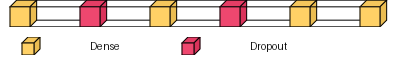

In [91]:
visualkeras.layered_view(model_deep, legend=True, scale_xy=1, scale_z=0.1, max_z=100, spacing=50)

In [92]:
# Train the Deep model using these callbacks
print("\nTraining Deep Model...")
history_deep = model_deep.fit(
    X_train, 
    y_train, 
    epochs=100,            # Deep models often need more time
    batch_size=32, 
    validation_split=0.1, 
    callbacks=[reduce_lr, early_stopping]
)


Training Deep Model...
Epoch 1/100
428/428 [==============================] - 3s 8ms/step - loss: 6483.0322 - accuracy: 0.6546 - val_loss: 3195.7092 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 2/100
428/428 [==============================] - 3s 8ms/step - loss: 5304.6226 - accuracy: 0.6697 - val_loss: 6483.3628 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 3/100
428/428 [==============================] - 3s 8ms/step - loss: 6362.6299 - accuracy: 0.6607 - val_loss: 2204.4275 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 4/100
428/428 [==============================] - 3s 7ms/step - loss: 6859.3350 - accuracy: 0.6635 - val_loss: 5371.0034 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 5/100
428/428 [==============================] - 3s 7ms/step - loss: 7437.4858 - accuracy: 0.6591 - val_loss: 4556.4629 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 6/100
428/428 [==============================] - 3s 7ms/step - loss: 5669.6831 - accuracy: 0.6730 - val_loss: 12171.5322 - val_accuracy: 0.6413 - lr: 0.0010
Epo

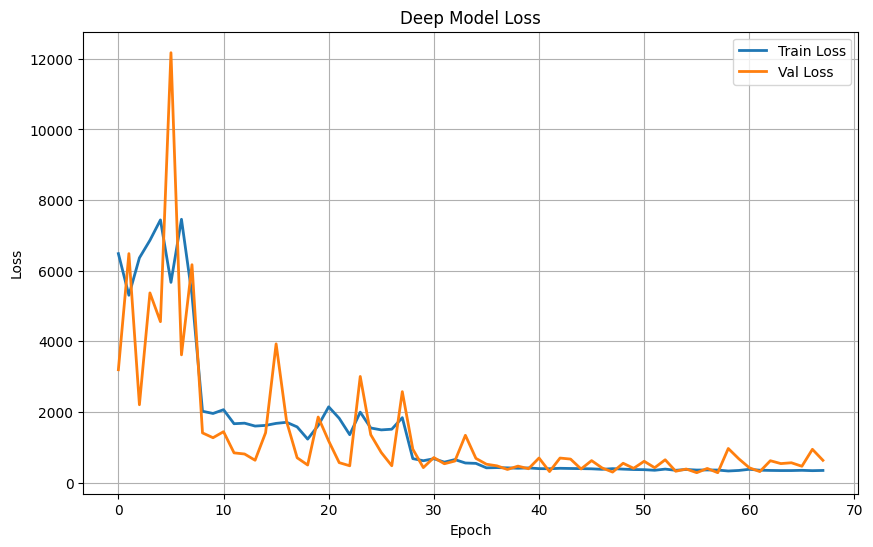

In [93]:
# --- 2. Plot Training & Validation Loss ---
plt.figure(figsize=(10, 6))
plt.plot(history_deep.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_deep.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Deep Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

119/119 [==============================] - 0s 2ms/step


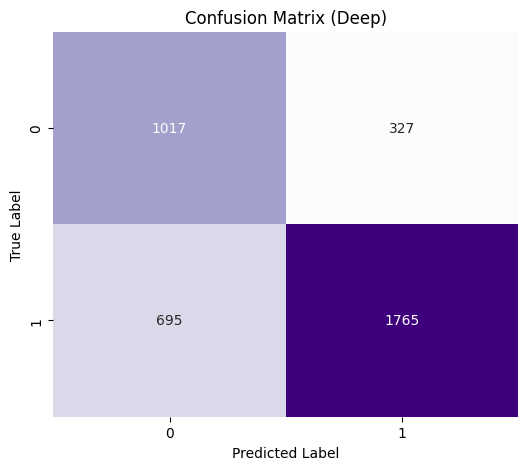

In [94]:
# --- 3. Confusion Matrix ---
y_pred_deep = (model_deep.predict(X_test) > 0.5).astype("int32")

cm_deep = confusion_matrix(y_test, y_pred_deep)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix (Deep)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [95]:
# Print Classification Report
print(classification_report(y_test, y_pred_deep))

              precision    recall  f1-score   support

           0       0.59      0.76      0.67      1344
           1       0.84      0.72      0.78      2460

    accuracy                           0.73      3804
   macro avg       0.72      0.74      0.72      3804
weighted avg       0.76      0.73      0.74      3804



We see that our learinig process has a lot of jitter. To slove this we will use Batch Normalization

Batch Normalization smooths out the learning process. Instead of just `Dense -> Dropout`, we change the block structure to: **`Dense Layer` $\rightarrow$ `Batch Normalization` $\rightarrow$ `Activation (ReLU)` $\rightarrow$ `Dropout`**.

This standardizes inputs between layers, allowing the model to train faster and creating a smooth loss curve that Early Stopping can track easily.

In [96]:
from tensorflow.keras.layers import BatchNormalization

In [97]:
# Define a robust Deep Model
model_robust = Sequential()

# --- Block 1 ---
model_robust.add(Dense(64, input_shape=(10,))) # No activation here!
model_robust.add(BatchNormalization())         # Normalize the weights
model_robust.add(Activation('relu'))           # Activation happens AFTER normalization
model_robust.add(Dropout(0.2))

# --- Block 2 ---
model_robust.add(Dense(64))
model_robust.add(BatchNormalization())
model_robust.add(Activation('relu'))
model_robust.add(Dropout(0.2))

# --- Block 3 ---
model_robust.add(Dense(64))
model_robust.add(BatchNormalization())
model_robust.add(Activation('relu'))
model_robust.add(Dropout(0.2))

# --- Output Layer ---
model_robust.add(Dense(1, activation='sigmoid'))

In [98]:
model_robust.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                704       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                     

In [103]:
early_stopping_robust = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,      
    patience=10,         
    restore_best_weights=True,
    verbose=1
)

reduce_lr_robust = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [104]:
model_robust.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [105]:
print("Training Robust Model with Batch Norm...")
history_robust = model_robust.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1, 
    callbacks=[reduce_lr_robust, early_stopping_robust]
)

Training Robust Model with Batch Norm...
Epoch 1/100
428/428 [==============================] - 8s 15ms/step - loss: 0.4477 - accuracy: 0.7962 - val_loss: 0.3596 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 2/100
428/428 [==============================] - 5s 13ms/step - loss: 0.3946 - accuracy: 0.8281 - val_loss: 0.3397 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 3/100
428/428 [==============================] - 6s 13ms/step - loss: 0.3706 - accuracy: 0.8421 - val_loss: 0.3314 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 4/100
428/428 [==============================] - 6s 15ms/step - loss: 0.3608 - accuracy: 0.8469 - val_loss: 0.3385 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 5/100
428/428 [==============================] - 5s 13ms/step - loss: 0.3544 - accuracy: 0.8504 - val_loss: 0.3269 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 6/100
428/428 [==============================] - 5s 13ms/step - loss: 0.3492 - accuracy: 0.8530 - val_loss: 0.3295 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 7/100
428/4

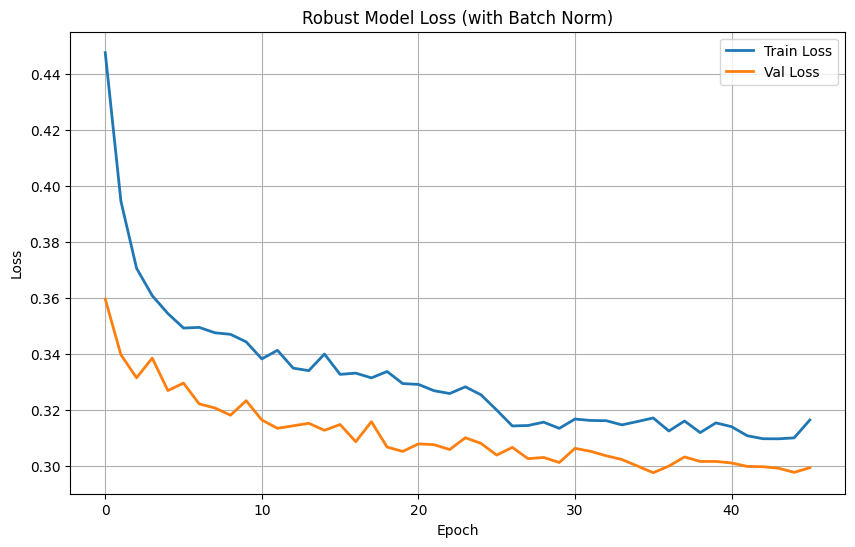

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_robust.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_robust.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Robust Model Loss (with Batch Norm)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

**Dropout Layer:**

During training, the dropout layer randomly "drops out" (i.e., temporarily removes) a number of neuron outputs in the layer, along with their connections. This means that at each iteration of training, a different set of neurons is active, and the network cannot rely on any specific neuron for the correct output; the absence of those neurons forces other neurons to handle the representation required to make predictions, spreading out the responsibility and potentially learning more robust features.

The "dropout rate" is the fraction of neurons that are dropped out. This is a hyperparameter that can be tuned. A common dropout rate is 50%, but this can vary depending on the size and complexity of the network.

At test time (i.e., when making predictions on new data), dropout is not applied; instead, the network uses all of its neurons. However, to compensate for the larger number of active neurons relative to the training phase, the outputs of the neurons during testing are typically scaled down by the dropout rate, averaging out the contribution of each neuron.

In neural networks, a dropout layer is a form of regularization technique that helps prevent overfitting. Overfitting occurs when a model learns the training data too well, including noise and fluctuations that do not apply to new data. This can result in a model that performs well on the training data but poorly on unseen data.

By applying dropout, neural networks become less sensitive to specific weights of neurons, which leads to a more generalized model. It’s a bit like ensuring that every neuron has a backup and that the network is robust enough to provide accurate predictions even if some of its parts were to fail or be absent.

**EarlyStopping**

The EarlyStopping callback stops training when a monitored metric has stopped improving. Parameters include:

monitor: Similar to ReduceLROnPlateau, this is the metric to be monitored, which in this case is again 'val_loss'.
patience: This parameter is the number of epochs with no improvement after which training will be stopped. With patience=3, training will stop if there's no decrease in val_loss for 3 consecutive epochs.
EarlyStopping helps prevent overfitting by stopping the training process if the model is no longer improving on the validation data. This is a form of regularization strategy.

These two callbacks are often used together during the training of a neural network to improve model performance and to prevent overfitting. The ReduceLROnPlateau allows the model to escape plateaus in the loss landscape by taking smaller steps, while EarlyStopping ensures that you don't continue to train once it becomes clear that the model is not making any further improvements.

---

## Metrics Recap (Just a refresher)

**Accuracy:**

What it measures: The ratio of correctly predicted observations to the total observations.
Best used when: The class distribution is similar, or when true positives and true negatives are more important.
Formula: (True Positives + True Negatives) / Total Observations

**Precision (Positive Predictive Value):**

What it measures: The ratio of correctly predicted positive observations to the total predicted positives. It's about being precise, i.e., how many of the items labeled as positive are actually positive.
Best used when: The cost of a false positive is high (e.g., in spam detection, you don't want non-spam emails to be labeled as spam).
Formula: True Positives / (True Positives + False Positives)

**Recall (Sensitivity, True Positive Rate):**

What it measures: The ratio of correctly predicted positive observations to the all observations in actual class - yes. It answers the question: Of all the items that are truly positive, how many were correctly identified?
Best used when: The cost of a false negative is high (e.g., in fraud detection, it's vital to catch as many fraud cases as possible).
Formula: True Positives / (True Positives + False Negatives)

**F1 Score:**

What it measures: The weighted average of Precision and Recall. This score takes both false positives and false negatives into account, and is a measure of the test's accuracy.
Best used when: You want to balance the trade-off between Precision and Recall, especially if there's an uneven class distribution (e.g., when one class is rare).
Formula: 2 * (Precision * Recall) / (Precision + Recall)

Each of these metrics gives you different insights into the performance of your classification model, and it's important to consider them in context rather than in isolation. Depending on the specific requirements and cost of errors in your application, you might prioritize one of these metrics over the others.